In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

In [3]:
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.32MB/s]


In [6]:
image, label = train_dataset[0]
print(image.shape)
print(len(train_dataset))

torch.Size([1, 28, 28])
60000


In [7]:
image, label = test_dataset[0]
print(image.shape)
print(len(test_dataset))

torch.Size([1, 28, 28])
10000


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [9]:
class CNNClassifier (nn.Module):
  def __init__(self):
    super (CNNClassifier, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(128 * 3 * 3, 128)
    self.fc2 = nn.Linear (128, 64)
    self.fc3 = nn.Linear (64, 10)
  def forward(self, x):
    x = self.pool(torch.relu(self.conv1(x)))
    x = self.pool(torch.relu (self.conv2(x)))
    x = self.pool(torch.relu(self.conv3(x)))
    x = x.view(x.size(0), -1) # Flatten the image
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [10]:
from torchsummary import summary
model = CNNClassifier()
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
print('Name: MONISH N')
print('Register Number: 212223240097')
summary(model, input_size=(1, 28, 28))

Name: MONISH N
Register Number: 212223240097
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 7, 7]          73,856
         MaxPool2d-6            [-1, 128, 3, 3]               0
            Linear-7                  [-1, 128]         147,584
            Linear-8                   [-1, 64]           8,256
            Linear-9                   [-1, 10]             650
Total params: 249,162
Trainable params: 249,162
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.42
Params size (MB): 0.95
Estimated Total Size (MB): 1.3

In [11]:
# Initialize model, loss function, and optimizer
model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [17]:
def train_model(model, train_loader, num_epochs=3):
    # Move model to GPU if available, inside the function
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            # Move images and labels to the same device as the model
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print('Name: MONISH N')
        print('Register Number: 212223240097')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

In [18]:
train_model(model, train_loader)

Name: MONISH N
Register Number: 212223240097
Epoch [1/3], Loss: 0.4799
Name: MONISH N
Register Number: 212223240097
Epoch [2/3], Loss: 0.2926
Name: MONISH N
Register Number: 212223240097
Epoch [3/3], Loss: 0.2478


In [19]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    # Get the device the model is on
    device = next(model.parameters()).device

    with torch.no_grad():
        for images, labels in test_loader:
            # Move images and labels to the same device as the model
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print('Name: MONISH N')
    print('Register Number: 212223240097')
    print(f'Test Accuracy: {accuracy:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    print('Name: MONISH N')
    print('Register Number: 212223240097')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print('Name: MONISH N')
    print('Register Number: 212223240097')
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

Name: MONISH N
Register Number: 212223240097
Test Accuracy: 0.8994
Name: MONISH N
Register Number: 212223240097


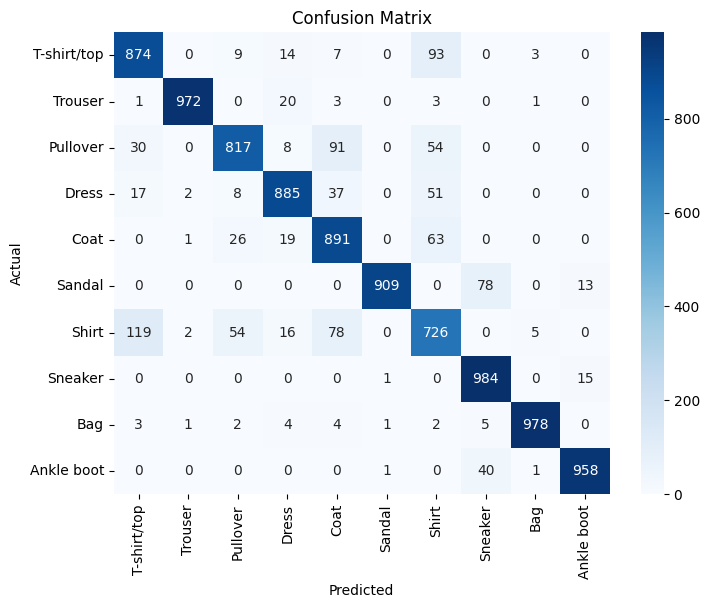

Name: MONISH N
Register Number: 212223240097
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.87      0.86      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.89      0.82      0.85      1000
       Dress       0.92      0.89      0.90      1000
        Coat       0.80      0.89      0.84      1000
      Sandal       1.00      0.91      0.95      1000
       Shirt       0.73      0.73      0.73      1000
     Sneaker       0.89      0.98      0.93      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [20]:
test_model(model, test_loader)


In [21]:
import matplotlib.pyplot as plt
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]

    # Get the device the model is on
    device = next(model.parameters()).device

    # Move the image to the same device as the model
    image = image.to(device)

    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))  # Add batch dimension and move to device
        _, predicted = torch.max(output, 1)
    class_names = dataset.classes

    # Display the image
    print('Name: MONISH N')
    print('Register Number: 212223240097')
    plt.imshow(image.cpu().squeeze(), cmap="gray") # Move back to CPU for display
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted.item()]}')
    plt.axis("off")
    plt.show()
    print(f'Actual: {class_names[label]}, Predicted: {class_names[predicted.item()]}')

Name: MONISH N
Register Number: 212223240097


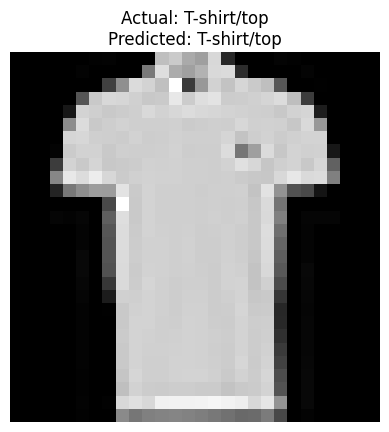

Actual: T-shirt/top, Predicted: T-shirt/top


In [22]:
predict_image(model, image_index=85, dataset=test_dataset)